In [9]:
import torch
import context
from ccn import Constraint, ConstraintsGroup, Clause, ClausesGroup, Literal, ConstraintsLayer
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [20]:
constraints = ConstraintsGroup('../constraints/full')
print(len(constraints))

clauses = ClausesGroup.from_constraints_group(constraints)
print(len(clauses))

centrality = 'rev-katz'

centrality = np.array(
  [7,40,23,5,27,28,39,18,19,21,38,22,16,11,20,33,9,30,3,24,4,15,34,31,25,26,13,17,29,37,14,36,12,35,6,0,10,32,2,1,8]
)
#centrality = centrality[::-1]

constraints = clauses.stratify(centrality)
strata = len(constraints)
print(strata)

print(constraints[0].heads())

lens = [len(group) for group in constraints]
print(lens)
print(sum(lens))

243
243
18
{37, 5, 39}
[3, 7, 8, 8, 19, 5, 11, 10, 17, 16, 8, 21, 13, 19, 49, 31, 29, 30]
304


In [7]:
layer = ConstraintsLayer(constraints, 41)
preds = torch.tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

updated = layer(preds)
assert (updated == preds).all()

fuzzy = 0.2 + preds * 0.8 + torch.rand_like(preds) * 0.1
fuzzy = torch.rand_like(preds) * 0.3
updated = layer(fuzzy, goal=preds)
print(updated)

assert ((updated < 0.5) == (fuzzy < 0.5)).all()

tensor([[0.2145, 0.2917, 0.1906, 0.1749, 0.1749, 0.1043, 0.1757, 0.1278, 0.7083,
         0.0894, 0.1926, 0.2195, 0.1571, 0.2377, 0.1749, 0.2008, 0.2697, 0.1366,
         0.0617, 0.1041, 0.0453, 0.1598, 0.1749, 0.0714, 0.1906, 0.2917, 0.2202,
         0.0269, 0.2145, 0.2203, 0.1858, 0.1915, 0.2917, 0.2687, 0.2414, 0.0857,
         0.0560, 0.1559, 0.1331, 0.1745, 0.1032, 0.2427, 0.2579, 0.1034, 0.0549,
         0.2799, 0.0794, 0.0164, 0.0291, 0.0320, 0.2284, 0.0426, 0.1294, 0.2465,
         0.1498, 0.2735, 0.0109, 0.1617, 0.0159, 0.0540, 0.2137, 0.0114, 0.2022,
         0.2615, 0.0202, 0.0332, 0.1547, 0.1892, 0.0241, 0.1123, 0.2989, 0.2409,
         0.2039, 0.1110, 0.0213, 0.1693, 0.1948, 0.2821, 0.1948, 0.2371, 0.0511,
         0.0431, 0.1586, 0.0777, 0.1384, 0.1955, 0.2165, 0.1326, 0.2084, 0.2721,
         0.0146, 0.2308, 0.2714, 0.2173, 0.1507, 0.1818, 0.2786, 0.0539, 0.1249,
         0.0854, 0.1789, 0.2451, 0.1348, 0.1334, 0.0706, 0.1642, 0.2478, 0.0613,
         0.0820, 0.1715, 0.2

AssertionError: 

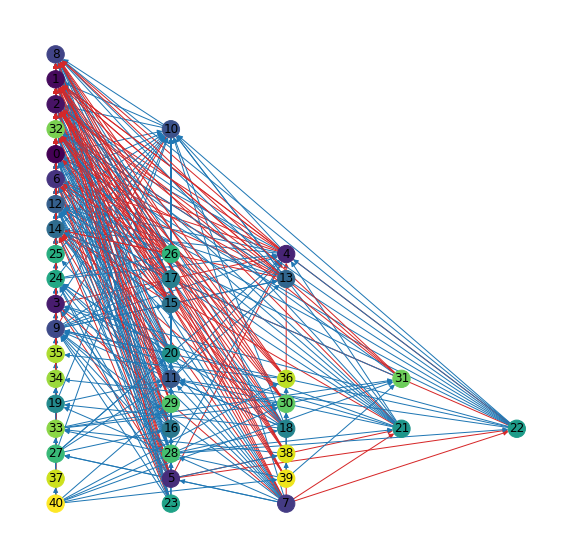

In [21]:
aux = ConstraintsGroup([])
for group in constraints:
  aux = aux + group 

G = aux.graph()

plt.figure(figsize=(10, 10))
ax = plt.subplot()

pos = dict()
for aid, atom in enumerate(aux.atoms().difference(aux.heads())):
  pos[atom] = (aid, -1)
for gid, group in enumerate(constraints):
  for aid, atom in enumerate(group.heads()):
    pos[atom] = (aid, gid)

# centrality = clauses.centrality(centrality)
centrality = {node: node for node in G.nodes()}

edge_color = ['tab:blue' if G[edge[0]][edge[1]]['body'] else 'tab:red' for edge in G.edges()]
node_color = [centrality[node] for node in G.nodes()]

nx.draw(G, with_labels=True, pos=pos, edge_color=edge_color, node_color=node_color)
plt.show()

In [ ]:
G = aux.duograph()

outer = [str(Literal(atom, True)) for atom in range(42)]
inner = [str(Literal(atom, False)) for atom in range(42)]

plt.figure(figsize=(10, 10))
ax = plt.subplot()
pos = nx.shell_layout(G, [inner, outer])
nx.draw(G, pos=pos, with_labels=True)
plt.show()

In [ ]:
constraints = ConstraintsGroup('../constraints/example')
clauses = ClausesGroup.from_constraints_group(constraints)

plt.figure(figsize=(10, 10))
ax = plt.subplot()
nx.draw_planar(clauses.graph(), with_labels=True)
plt.show()